In [302]:
from firecrawl import FirecrawlApp
from pydantic import BaseModel, Field
from typing import List, TypedDict , Optional, Type
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.callbacks import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
import os
import requests
from langchain_core.tools import BaseTool
from langgraph.graph import START,END, StateGraph
from langchain_core.prompts import ChatPromptTemplate

In [121]:
load_dotenv()


True

In [272]:
llm=ChatOpenAI() 

In [273]:
class State(TypedDict):
    web_search: List[dict]
    structured_response: List[str]
    emails: List[str]
    phonenumbers: List[str]
    create_record: str
    email_drafts: str
    email_drafts_markdown: str
    

In [274]:
def search(state: State) -> State:
    tavily_tool = TavilySearchResults(max_results=1)
    search_query = '"real estate company" site:.com"'
    state["web_search"] = tavily_tool.invoke(search_query)
    return state

In [275]:
class SearchResponse(BaseModel):
    url: List[str]

def structured_response(state: State) -> State:
    web_search = state["web_search"]
    urls = [result['url'] for result in web_search]


    prompt = """
    You are a senior search assistant, you have access to search some url dictionary from a search assistant. Your role is to extract all urls from the {web_search}. Return them as a list.
    """

    chat_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", prompt),
            ("human", "{web_search}"),
        ]
    )

    structure = llm.with_structured_output(SearchResponse)

    structured = chat_prompt | structure 

    structured_response = structured.invoke({"web_search": urls})

    return {"structured_response":structured_response.url}



In [ ]:
def get_contact(state:State):
    structured_response=state["structured_response"]   
    class ContactInfo(BaseModel):
        phonenumber: str
        email: str

    class WebsitecontactInfo(BaseModel):
        info: List[ContactInfo]

    class ContactExtractorInput(BaseModel):
        url: str = Field(..., description="Website URL to extract contact information from")

    class CustomContactExtractorTool(BaseTool):
        name: str = "website_contact_extractor"
        description: str = "Extracts company contact information from website URLs including phone numbers and emails"
        args_schema: Type[BaseModel] = ContactExtractorInput

        def _run(
            self, 
            url: str,
            run_manager: Optional[CallbackManagerForToolRun] = None
        ) -> WebsitecontactInfo:
            """Main execution method for contact extraction"""
            try:
                firecrawl_api_key = os.getenv('FIRECRAWL_API_KEY')
                if not firecrawl_api_key:
                    raise ValueError("FIRECRAWL_API_KEY environment variable not found")
                    
                app = FirecrawlApp(api_key=firecrawl_api_key)
                response = app.extract([url], {
                    'prompt': '''Extract all company contact information including:
                                - Phone number
                                - Email address
                                Return structured JSON data''',
                    'schema': {
                        'type': 'object',
                        'properties': {
                            'phonenumber': {'type': 'string'},
                            'email': {'type': 'string'}
                        }
                    }
                })
                
                data = response['data']
                contact_info = ContactInfo(
                    phonenumber=data.get('phonenumber', ''),
                    email=data.get('email', '')
                )
                website_info = WebsitecontactInfo(info=[contact_info])
                return website_info
                
            except Exception as e:
                return WebsitecontactInfo(info=[])

        async def _arun(
            self, 
            url: str,
            run_manager: Optional[AsyncCallbackManagerForToolRun] = None
        ) -> WebsitecontactInfo:
            """Async version using same sync implementation"""
            return self._run(url, run_manager)

    tool = CustomContactExtractorTool() 
    phonenumbers = []
    emails = []

    for url in structured_response:
        contact = tool.invoke({"url": url})  

        for info in contact.info[:5]: 
            phonenumbers.append(info.phonenumber) 
            emails.append(info.email)  

    state["phonenumbers"] = phonenumbers  
    state["emails"] = emails  
    return state


In [303]:
def record(state: State):
    emails = state["emails"]
    phonenumbers = state["phonenumbers"]
    class AirtableInput(BaseModel):
        emails: List[str] = Field(..., description="List of email addresses")
        phonenumbers: List[str] = Field(..., description="List of phone numbers")

    class AirtableTool(BaseTool):
        name: str = "airtable_recorder"
        description: str = "Adds contact information to Airtable database"
        args_schema: Type[BaseModel] = AirtableInput

        def _run(
            self, 
            emails: List[str],
            phonenumbers: List[str],
            run_manager: Optional[CallbackManagerForToolRun] = None
        ) -> str:
            """Main execution method for adding records to Airtable"""
            emails_subset = emails[:5]
            phonenumbers_subset = phonenumbers[:5]

            records = []
            for email, phone in zip(emails_subset, phonenumbers_subset):
                records.append({
                    "fields": {
                        "Email Address": email,
                        "Phone Number": phone
                    }
                })

            url = "https://api.airtable.com/v0/appTbNJ0F0exvFSFw/Email%20Campaign"
            api_token = os.getenv('AIRTABLE_API_KEY')
            if not api_token:
                raise ValueError("AIRTABLE_API_KEY environment variable not found")
            
            headers = {
                "Authorization": f"Bearer {api_token}",
                "Content-Type": "application/json"
            }
        
            data = {"records": records}
        
            try:
                response = requests.post(url, headers=headers, json=data)
                response.raise_for_status()
                return "Airtable record created successfully"
            except requests.exceptions.HTTPError as err:
                return f"Error creating Airtable record: {str(err)}"

        async def _arun(
            self, 
            emails: List[str],
            phonenumbers: List[str],
            run_manager: Optional[AsyncCallbackManagerForToolRun] = None
        ) -> str:
            """Async version using same sync implementation"""
            return self._run(emails, phonenumbers, run_manager)
        
    tool = AirtableTool()
    create_record = tool.invoke({"emails": emails, "phonenumbers": phonenumbers})
    return {"create_record": create_record}

In [295]:

class MessageDraft(BaseModel):
    subject: str = Field(..., description="Subject of the email")
    body: str = Field(..., description="Body content of the email")

def create_email_drafts(state: State):
    emails = state["emails"]
    drafts = []
    
    structured_output = llm.with_structured_output(MessageDraft)

    for email in emails:
        structured_response = structured_output.invoke(
            f"You are a top-performing tech sales executive for Cribblr, an AI agency specializing in voice agents for real estate. Your tasks: 1. Craft a highly personalized email that demonstrates a deep understanding of the recipient's business. 2. Highlight how Cribblr's voice agents can solve specific real estate challenges. 3. Maintain a professional yet conversational tone. 4. Follow email best practices (clear structure, strong CTAs). 5. Use company research to make relevant references. You have access to the email: {email}"
        )
        drafts.append({
            "to_email": email,
            "draft": structured_response
        })

    state["email_drafts"] = drafts

    # Generate a Markdown formatted string for display
    formatted_emails = "\n\n".join(
        f"To: {email.get('to_email', 'Not provided')}\nSubject: {email['draft'].subject}\n\n{email['draft'].body}"
        for email in drafts
    )
    state["email_drafts_markdown"] = formatted_emails

    return state


In [296]:
workflow = StateGraph(State)

workflow.add_node("tavily_tool", search)
workflow.add_node("structured", structured_response)
workflow.add_node("get_contact", get_contact)
workflow.add_node("record", record)
workflow.add_node("create_email_drafts", create_email_drafts)

workflow.add_edge("tavily_tool", "structured")
workflow.add_edge("structured", "get_contact")
workflow.add_edge("get_contact", "record")
workflow.add_edge("record", "create_email_drafts")
workflow.add_edge("create_email_drafts", END)
workflow.set_entry_point("tavily_tool")
graph = workflow.compile()

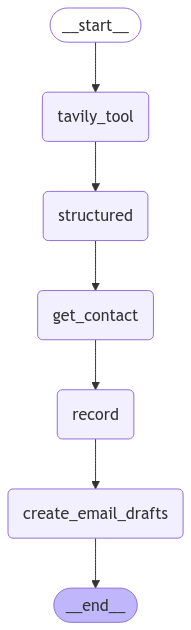

In [297]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [304]:
result = graph.invoke({"web_search": "real estate company in US",})


In [305]:
from IPython.display import Markdown
Markdown(result["email_drafts_markdown"])

To: 
Subject: Transforming Your Real Estate Business with Cribblr's Voice Agents

Dear [Recipient's Name],

I hope this message finds you well. I recently came across [Recipient's Company Name] and was impressed by the innovative approach you are taking in the real estate industry. It's evident that your commitment to leveraging technology for growth aligns perfectly with Cribblr's mission.

At Cribblr, we understand the challenges faced by real estate businesses like yours. From streamlining property searches to enhancing customer engagement, our AI-powered voice agents are designed to revolutionize the way you interact with clients. Imagine providing personalized property recommendations to potential buyers or scheduling property viewings effortlessly - all through a seamless voice interface.

Our team at Cribblr is dedicated to ensuring that your real estate business stays ahead of the curve. By integrating our voice agents into your operations, you can automate routine tasks, improve response times, and deliver exceptional customer experiences.

I would love to explore how Cribblr's innovative solutions can specifically address the unique challenges faced by [Recipient's Company Name]. Would you be available for a brief discussion to see how we can tailor our voice agents to meet your business objectives?

Looking forward to the opportunity to collaborate and drive success for your real estate business.

Warm regards,
[Your Name]
Top-Performing Tech Sales Executive
Cribblr - Your AI Partner in Real Estate